C:\Users\vatsa\AppData\Roaming\Python\Python312\site-packages\face_recognition_models\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


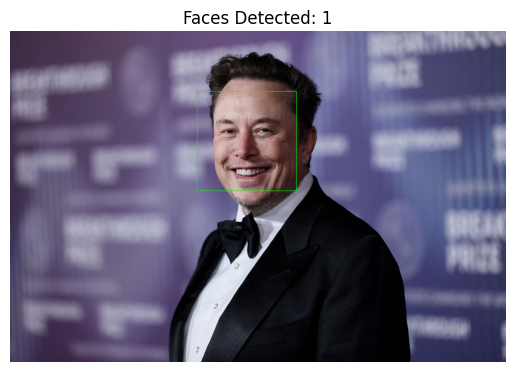

Found 1 face(s) using Haar Cascade in C:\Users\vatsa\Python\Mac\known\elon.jpg


In [1]:
import cv2
import matplotlib.pyplot as plt
import face_recognition
import numpy as np
import os

def detect_faces_haar_cascade(image_path):
    # Load the pre-trained Haar Cascade classifier for frontal faces
    # You might need to adjust the path to the XML file based on your OpenCV installation
    # A common path: cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Convert the image to grayscale (Haar cascades work best on grayscale)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    # scaleFactor: How much the image size is reduced at each image scale.
    # minNeighbors: How many neighbors each candidate rectangle should have to retain it.
    # minSize: Minimum possible object size. Objects smaller than that are ignored.
    faces = face_classifier.detectMultiScale(
        gray_img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    # Draw rectangles around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green rectangle, thickness 2

    # Display the image (OpenCV uses BGR, Matplotlib uses RGB, so convert for display)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Faces Detected: {len(faces)}")
    plt.axis('off')
    plt.show()

    print(f"Found {len(faces)} face(s) using Haar Cascade in {image_path}")

# Example Usage:
# Save an image named 'test_image.jpg' in the same directory as your script
# Or provide a full path like 'C:/Users/YourUser/Pictures/my_face.jpg'
detect_faces_haar_cascade("C:\\Users\\vatsa\\Python\\Mac\\known\\elon.jpg")

In [2]:
# --- 1. Enrollment Phase: Load known faces and their encodings ---
known_face_encodings = []
known_face_names = []
known_faces_dir = "C:\\Users\\vatsa\\Python\\Mac\\known" # Directory containing images of known people

print("Loading known faces...")
if not os.path.exists(known_faces_dir):
    print(f"Error: Directory '{known_faces_dir}' not found. Please create it and add images of known people.")
else:
    for filename in os.listdir(known_faces_dir):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(known_faces_dir, filename)
            image = face_recognition.load_image_file(path)
            
            # Get face encodings from the image. Assumes one face per image for known_faces.
            # If multiple faces, you might need to select the primary one.
            face_encodings = face_recognition.face_encodings(image)
            
            if face_encodings:
                known_face_encodings.append(face_encodings[0])
                # Use filename (without extension) as the person's name
                known_face_names.append(os.path.splitext(filename)[0])
                print(f"Loaded: {known_face_names[-1]}")
            else:
                print(f"Warning: No face found in {filename}. Skipping.")
print(f"Loaded {len(known_face_names)} known faces.")

# Initialize some variables for real-time recognition
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

# --- 2. Recognition Phase: Process live video from webcam ---
video_capture = cv2.VideoCapture(0) # 0 for default webcam

if not video_capture.isOpened():
    print("Error: Could not open video stream. Make sure webcam is connected.")
else:
    print("\nStarting real-time face recognition. Press 'q' to quit.")
    while True:
        # Grab a single frame of video
        ret, frame = video_capture.read()
        if not ret:
            print("Failed to grab frame from webcam.")
            break

        # Resize frame of video to 1/4 size for faster face recognition processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

        # Only process every other frame to save time
        if process_this_frame:
            # Find all the faces and face encodings in the current frame of video
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

            face_names = []
            for face_encoding in face_encodings:
                # Compare the detected face with known faces
                matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
                name = "Unknown"

                # Find the best match
                face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = known_face_names[best_match_index]

                face_names.append(name)

        process_this_frame = not process_this_frame

        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2) # Red for detected face

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.8, (255, 255, 255), 1) # White text

        # Display the resulting image
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release handle to the webcam
    video_capture.release()
    cv2.destroyAllWindows()

Loading known faces...
Loaded: amb
Loaded: elon
Loaded: me
Loaded: Modi
Loaded 4 known faces.

Starting real-time face recognition. Press 'q' to quit.
